In [1]:
import os
import glob
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute DICE Coefficients From Images

### Function to get all files sorted in a directory:

In [2]:
def get_files(pattern):
    """
    Extract files in alphanumerical order that match the provided pattern
    """
    if isinstance(pattern, list):
        pattern = os.path.join(*pattern)
        
    files = natsort.natsorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError('Pattern could not detect file(s)')
        
    return files

### Input Cell:
Place your path to input and output directories in `" "`.

In [3]:
data_dir = 'data/images'
output_dir = 'outputs'

Load images from `data_dir`:

In [4]:
import re

data_files = get_files(data_dir + '/*.jpg')
print('There are {} images in data directory'.format(len(data_files)))

# split by colors:
cyan_data = [val for val in data_files if re.search(r'cyan\.jpg', val)]
yellow_data = [val for val in data_files if re.search(r'yellow\.jpg', val)]
magenta_data = [val for val in data_files if re.search(r'(mag|magenta)\.jpg', val)]

# get events:
events = [val.split('_')[1] for val in cyan_data]
assert len(events) == len(data_files)/3

# sanity check to make sure they are the same number of files
assert len(cyan_data)==len(yellow_data)==len(magenta_data)

There are 6 images in data directory


Per Event:
 - load the 3 channel's image data
 - convert from RGB to grayscale
 - threshold into binary images
 - compute similarity ([jaccard](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html))

In [34]:
from matplotlib import image
from sklearn.metrics import jaccard_score
from tqdm.notebook import tqdm

# function for RGB - Grayscale conversion
def rgb2gray(rgb):
    coeffs = np.array([0.2125, 0.7154, 0.0721])
    return np.dot(rgb, coeffs)

# pre-allocate for number of events
similarity_scores = pd.DataFrame(np.zeros([2, len(events)]), index=['yellow', 'magenta'], columns = events)
for i, event in enumerate(tqdm(events)):
    # read each event's image data as RGB
    cyan = image.imread(cyan_data[i])
    yellow = image.imread(yellow_data[i])
    magenta = image.imread(magenta_data[i])
    
    # concatenate into grayscale stacks, NxNx3 (cyan,yellow,magenta),
    event_data = np.stack((rgb2gray(cyan), rgb2gray(yellow), rgb2gray(magenta)), axis=2)
    
    # binarize based on threshold and compute similarity
    threshold = event_data.flatten().max() * 0.35     # could be adjusted
    event_bin = np.where(event_data>threshold, 1, 0)    # 0 or 1 based on threshold
    print(event)
    similarity_scores[event]['yellow'] = jaccard_score(event_bin[:,:,0], event_bin[:,:,1], average = 'micro')
    similarity_scores[event]['magenta'] = jaccard_score(event_bin[:,:,0], event_bin[:,:,2], average = 'micro')    

15
98



### Visualize:

<AxesSubplot:ylabel='Frequency'>

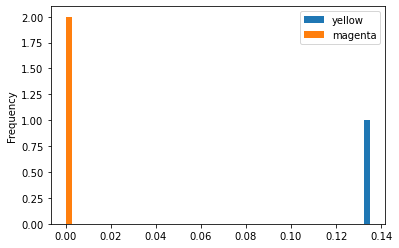

In [37]:
similarity_scores.transpose().plot.hist(bins=50)    # edit bins for bar width

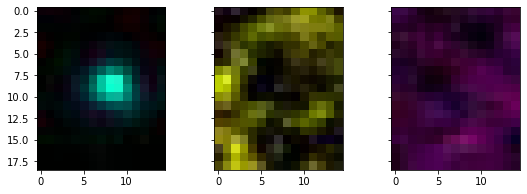

In [38]:
## optional cell, purely for visualizing images
fig,ax=plt.subplots(1,3, figsize=(9,3), sharey=True)
num_event = 1    # Put in number, starting at 0-{number of events -1}

cyan = image.imread(cyan_data[num_event])
yellow = image.imread(yellow_data[num_event])
magenta = image.imread(magenta_data[num_event])

ax[0].imshow(cyan, cmap=plt.get_cmap('gray'))
ax[1].imshow(yellow, cmap=plt.get_cmap('gray'))
ax[2].imshow(magenta, cmap=plt.get_cmap('gray'))